In [7]:
using PyCall, PyPlot, Statistics

In [8]:
mpl = pyimport("matplotlib");
mpl.rcParams["lines.linewidth"] = 2;

In [200]:
using ClimateMARGO
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Optimization
using ClimateMARGO.Plotting
using ClimateMARGO.PolicyResponse
include("ebm.jl");

# Policy scenario: SRM termination in 2050

In [201]:
SRM = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));

In [202]:
max_update = Dict("mitigate"=>nothing, "remove"=>nothing, "geoeng"=>1., "adapt"=>0.1);
max_deployment_noSRM = Dict("mitigate"=>1., "remove"=>1., "geoeng"=>0., "adapt"=>0.4);

In [203]:
optimize_controls!(SRM, obj_option="net_benefit");

Solve_Succeeded


In [204]:
only_SRM = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));
max_deployment_only_SRM = Dict("mitigate"=>0., "remove"=>0., "geoeng"=>1., "adapt"=>0.);
optimize_controls!(only_SRM, obj_option="net_benefit", max_deployment=max_deployment_only_SRM);
only_SRM_term = deepcopy(only_SRM)
step_forward!(only_SRM_term, 40.)
only_SRM_term.controls.geoeng[t(only_SRM_term) .> only_SRM_term.domain.present_year] .= 0.;

Solve_Succeeded


In [205]:
noSRM = deepcopy(SRM)
optimize_controls!(
    noSRM, obj_option="net_benefit",
    max_deployment=max_deployment_noSRM
);

Solve_Succeeded


In [206]:
SRM_term = deepcopy(SRM)
step_forward!(SRM_term, 40.)
terminate_year = Int(SRM_term.domain.present_year)
SRM_term_response = deepcopy(SRM_term)

ClimateModel("2060", Domain(5.0, 2060.0, 2020.0, 2200.0), Economics(100.0, 0.02, 0.0022222222222222222, 0.02, 8.5, 0.034, 13.0, 0.126, 4.5, 0, 0, 0, nothing, [7.5, 8.4375, 9.375, 10.3125, 11.25, 12.1875, 13.125, 14.0625, 15.0, 15.9375  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), Physics(460.0, 1.1, 4.977297891066924, 1.13, 106.0, 0.73, 0.5), Controls([0.0, 0.12500004986064675, 0.2500000996278413, 0.3750001491618611, 0.5000001977835616, 0.625000065492929, 0.6692207717842278, 0.7125931172478234, 0.7577033806735806, 0.8044739861076279  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.07364312105084603, 0.07870301164426369, 0.08424638878705423, 0.09006124448126919, 0.09615201344995554, 0.10252204864789854, 0.10916652516674866, 0.1160772440482244, 0.12324232094884593  …  0.23481741891646554, 0.2315628077257131, 0.2255153969959912, 0.21618487147662427, 0.20301

In [207]:
SRM_term.controls.geoeng[t(SRM_term) .> 2060] .= 0.;
SRM_term.domain.present_year = 2020.;

In [208]:
optimize_controls!(
    SRM_term_response, obj_option="net_benefit",
    max_deployment=max_deployment_noSRM, max_update=max_update
);
SRM_term_response.domain.present_year = 2020.;

Solve_Succeeded


In [209]:
using Interpolations

## SRM_term
F_lo = F(SRM_term_response, M=true, R=true, G=true);
t_lo = t(SRM_term_response)

Δt = 0.1
t_hi = 2020.:Δt:2200.

itp = interpolate((t_lo,), F_lo, Gridded(Linear()))
F_hi = itp(t_hi);

itp = interpolate((t_lo,), SRM_term_response.controls.adapt, Gridded(Linear()))
A_hi = itp(t_hi);

T_hi = DICE_EBM(t_hi, F_hi, default="Geoffroy-2013", Δt=Δt) .+ SRM_term_response.physics.T0;

## only_SRM_term
F_lo_only = F(only_SRM_term, M=true, R=true, G=true);
t_lo_only = t(only_SRM_term)

Δt = 0.1
t_hi_only = 2020.:Δt:2200.

itp = interpolate((t_lo_only,), F_lo_only, Gridded(Linear()))
F_hi_only = itp(t_hi_only);

itp = interpolate((t_lo_only,), only_SRM_term.controls.adapt, Gridded(Linear()))
A_hi_only = itp(t_hi_only);

T_hi_only = DICE_EBM(t_hi_only, F_hi_only, default="Geoffroy-2013", Δt=Δt) .+ only_SRM_term.physics.T0;

### Plots and calculations

In [210]:
using PyCall
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j);

##### Modified damage functions

In [211]:
damage(β, E, T, A, c, dt; discount=1., βCO2=0., βdTdt=0.) = ((1. .- A) .* ( (β .* E .* T.^2) .+ (βCO2 .* E .* (c.-280.)) .+ insert!(βdTdt .* (E[1:end-1] .+ E[2:end])/2. .* (diff(T)./dt).^2, 1, 0.) )) .* discount

damage(m; discounting=false, M=false, R=false, G=false, A=false, βCO2=0., βdTdt=0.) = damage(
    m.economics.β,
    E(m),
    T(m, M=M, R=R, G=G, A=A),
    0.,
    c(m, M=M, R=R),
    m.domain.dt,
    discount=1. .+ discounting * (discount(m) .- 1.),
    βCO2=βCO2,
    βdTdt=βdTdt
)

benefit(damage_baseline, damage) = damage_baseline .- damage
benefit(m::ClimateModel; discounting=false, M=false, R=false, G=false, A=false, βCO2=0., βdTdt=0.) = benefit(
    damage(m, discounting=discounting, βCO2=βCO2, βdTdt=βdTdt),
    damage(m, discounting=discounting, M=M, R=R, G=G, A=A, βCO2=βCO2, βdTdt=βdTdt)
)

net_benefit(benefit, cost) = benefit .- cost
net_benefit(m::ClimateModel; discounting=true, M=false, R=false, G=false, A=false, βCO2=0., βdTdt=0.) = net_benefit(
    benefit(m, discounting=discounting, M=M, R=R, G=G, A=A, βCO2=βCO2, βdTdt=βdTdt),
    cost(m, discounting=discounting, M=M, R=R, G=G, A=A)
)

net_present_benefit_mod(net_benefit, dt) = sum(net_benefit*dt)
net_present_benefit_mod(m::ClimateModel; discounting=true, M=false, R=false, G=false, A=false, βCO2=0., βdTdt=0.) = net_present_benefit_mod(
    net_benefit(m, discounting=discounting, M=M, R=R, G=G, A=A, βCO2=βCO2, βdTdt=βdTdt),
    m.domain.dt
)

net_present_benefit_mod (generic function with 2 methods)

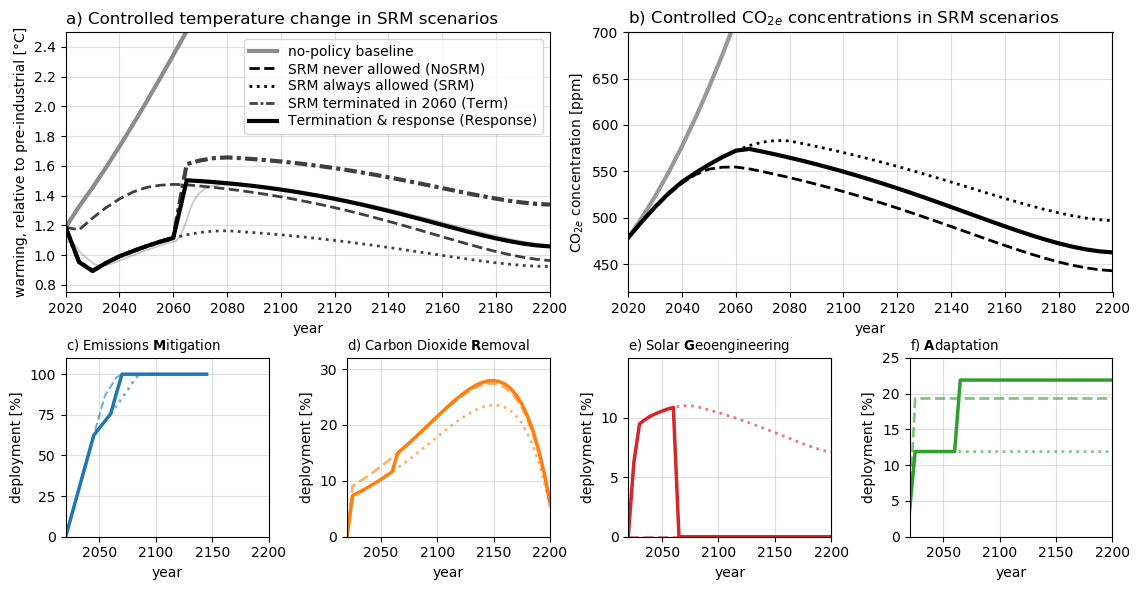

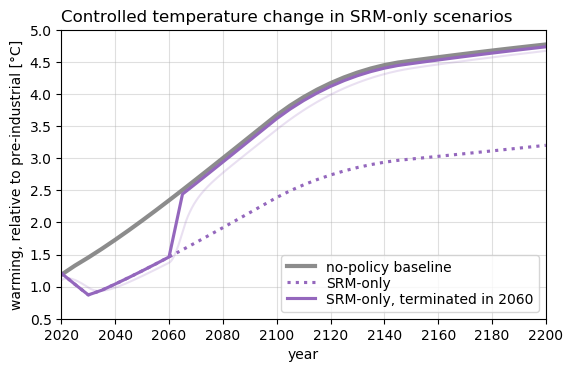

In [239]:
fig1 = figure(figsize=(11.5, 6))
gs = fig1.add_gridspec(7, 8)

##
ax1 = fig1.add_subplot(get(gs, (slice(0,4), slice(0,4))))

ax2 = fig1.add_subplot(get(gs,(slice(4,7), slice(0,2))))
ax2.set_ylim(0, 110)
ax2.set_yticks([0, 25, 50, 75, 100])

ax3 = fig1.add_subplot(get(gs,(slice(4,7), slice(2,4))))
ax3.set_ylim(0, 32)
ax3.set_yticks([0, 10, 20, 30])

ax4 = fig1.add_subplot(get(gs,(slice(4,7), slice(4,6))))
ax4.set_ylim(0, 15)
ax4.set_yticks([0, 5, 10])

ax5 = fig1.add_subplot(get(gs,(slice(4,7), slice(6,8))))
ax5.set_ylim(0, 25)
ax5.set_yticks([0, 5, 10, 15, 20, 25])

ax6 = fig1.add_subplot(get(gs, (slice(0,4), slice(4,8))))

for ax in [ax1, ax2, ax3, ax4, ax5]
    ax.grid(true, alpha=0.4)
    ax.set_xlim(2020., 2200.)
    ax.set_xlabel("year")
end

for ax in [ax2, ax3, ax4, ax5]
    ax.set_ylabel("deployment [%]")
end

ax1.plot(t(SRM),T(SRM), "-", color="grey", label="no-policy baseline", lw=3, alpha=0.9)
m = noSRM
ax1.plot(t(m),T(m, M=true, R=true, G=true, A=true), color="k", ls="--", lw=2, alpha=0.75)
m = SRM
ax1.plot(t(m),T(m, M=true, R=true, G=true, A=true), color="k", alpha=0.75, ls=":", lw=2)
m = SRM_term_response
ax1.plot(t_hi, T_hi.*sqrt.(1 .-A_hi), color="k", lw=1.5, ls="-", alpha=0.2)
ax1.plot(t(m),T(m, M=true, R=true, G=true, A=true), color="k", lw=3, ls="-")
m = SRM_term
ax1.plot(t(m),T(m, M=true, R=true, G=true, A=true), color="k", lw=3, alpha=0.75, ls=(0, (3,1,1,1)))

ax1.plot([],[], lw=2, ls="--", color="k", label="SRM never allowed (NoSRM)")
ax1.plot([],[], lw=2, ls=":", color="k", label="SRM always allowed (SRM)")
ax1.plot([],[], lw=2, alpha=0.75, ls=(0, (3,1,1,1)), color="k", label="SRM terminated in $(terminate_year) (Term)")
ax1.plot([],[], lw=3, ls="-", color="k", label="Termination & response (Response)")

ax1.legend(loc="upper right", labelspacing=0.25)
ax1.set_ylim([0.75, 2.5])
ax1.set_ylabel("warming, relative to pre-industrial [°C]")
ax1.set_title("a) Controlled temperature change in SRM scenarios", loc="left")

## 
m = noSRM
qidx = (m.economics.baseline_emissions .> 0)
ax2.plot(t(m)[qidx], m.controls.mitigate[qidx]*100, color="C0", ls="--", lw=1.5, alpha=0.6)
ax3.plot(t(m), m.controls.remove*100, color="C1", ls="--", lw=2, alpha=0.6)
ax4.plot(t(m), m.controls.geoeng*100, color="C3", ls="--", lw=2, alpha=0.6)
ax5.plot(t(m), m.controls.adapt*100, color="C2", ls="--", lw=2, alpha=0.6)

m = SRM
ax2.plot(t(m)[qidx], m.controls.mitigate[qidx]*100, color="C0", ls=":", lw=2, alpha=0.6)
ax3.plot(t(m), m.controls.remove*100, color="C1", ls=":", lw=2, alpha=0.6)
ax4.plot(t(m), m.controls.geoeng*100, color="C3", ls=":", lw=2, alpha=0.6)
ax5.plot(t(m), m.controls.adapt*100, color="C2", ls=":", lw=2, alpha=0.6)

m = SRM_term_response
ax2.plot(t(m)[qidx], m.controls.mitigate[qidx]*100, color="C0", ls="-", lw=2.5)
ax3.plot(t(m), m.controls.remove*100, color="C1", ls="-", lw=2.5)
ax4.plot(t(m), m.controls.geoeng*100, color="C3", ls="-", lw=2.5)
ax5.plot(t(m), m.controls.adapt*100, color="C2", ls="-", lw=2.5)

ax2.set_title(L"c) Emissions $\mathbf{M}$itigation", fontsize=9.5, loc="left")
ax3.set_title(L"d) Carbon Dioxide $\mathbf{R}$emoval", fontsize=9.5, loc="left")
ax4.set_title(L"e) Solar $\mathbf{G}$eoengineering", fontsize=9.5, loc="left")
ax5.set_title(L"f) $\mathbf{A}$daptation", fontsize=9.5, loc="left")

##
m = noSRM
ax6.plot(t(SRM), c(SRM), "-", color="grey", lw=3, alpha=0.8)
ax6.plot(t(m),c(m, M=true, R=true), color="k", ls="--", lw=2)
m = SRM
ax6.plot(t(m),c(m, M=true, R=true), color="k", ls=":", lw=2)
m = SRM_term_response
ax6.plot(t(m),c(m, M=true, R=true), color="k", ls="-", lw=3)

ax6.set_ylim(420, 700)
ax6.grid(true, alpha=0.4)
ax6.set_xlim(2020., 2200.)
ax6.set_xlabel("year")
ax6.set_ylabel(L"CO$_{2e}$ concentration [ppm]")
ax6.set_title(L"b) Controlled CO$_{2e}$ concentrations in SRM scenarios", loc="left")

fig1.tight_layout(w_pad=0.075, h_pad=0.075)
fig1.savefig("figures/SRM_termination_response.png", dpi=200., bbox_inches="tight")

fig2 = figure(figsize=(6.25,3.75))

##
plot(t(SRM),T(SRM), "-", color="grey", label="no-policy baseline", lw=3, alpha=0.9)
m = only_SRM
plot(t(m),T(m, M=true, R=true, G=true, A=true), lw=2.25, ls=":", color="C4", label="SRM-only")
m = only_SRM_term
plot(t_hi_only, T_hi_only.*sqrt.(1 .-A_hi_only), color="C4", lw=1.5, ls="-", alpha=0.2)
plot(t(m),T(m, M=true, R=true, G=true, A=true), lw=2.25, ls="-", color="C4", label="SRM-only, terminated in 2060")
ylim(0.5, 5.0)
legend(loc="lower right", labelspacing=0.14)
ylabel("warming, relative to pre-industrial [°C]")
title("Controlled temperature change in SRM-only scenarios", loc="left")
grid(true, alpha=0.4)
xlim(2020., 2200.)
xlabel("year")

fig2.savefig("figures/scenario-B_SRM_termination.png", dpi=250., bbox_inches="tight")


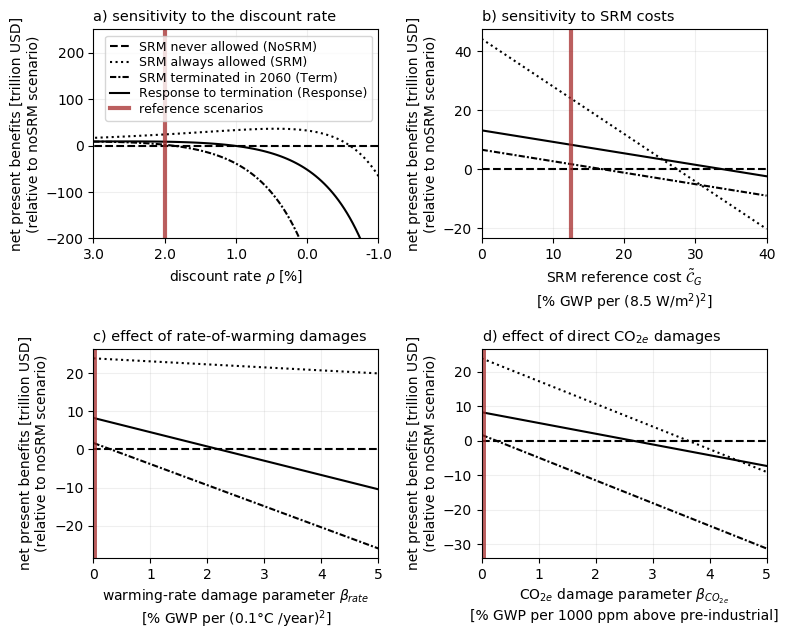

In [222]:
fig2 = figure(figsize=(8, 6.5))
ax1 = fig2.add_subplot(2,2,1)
ax2 = fig2.add_subplot(2,2,2)
#ax3 = fig2.add_subplot(2,2,3)
ax4 = fig2.add_subplot(2,2,3)
ax5 = fig2.add_subplot(2,2,4)

##
ρmax = 0.03
ρmin = -0.01
ρs = -0.01:(ρmax-ρmin)/100.:ρmax;

function NPB(m, ρ)
    tmp = deepcopy(m)
    tmp.economics.ρ = ρ
    return net_present_benefit(tmp, M=true, R=true, G=true, A=true)
end

NPB_mod_SRM_term_response = [NPB(SRM_term_response, ρ) for ρ in ρs]
NPB_mod_SRM_term = [NPB(SRM_term, ρ) for ρ in ρs]
NPB_mod_noSRM = [NPB(noSRM, ρ) for ρ in ρs]
NPB_mod_SRM = [NPB(SRM, ρ) for ρ in ρs]

ax1.grid(true, alpha=0.2)
ax1.plot(ρs, NPB_mod_noSRM-NPB_mod_noSRM, "k--", label="SRM never allowed (NoSRM)")
ax1.plot(ρs, NPB_mod_SRM-NPB_mod_noSRM, "k:", label="SRM always allowed (SRM)")
ax1.plot(ρs, NPB_mod_SRM_term-NPB_mod_noSRM, "k", ls=(0, (3,1,1,1)), label="SRM terminated in $(terminate_year) (Term)")
ax1.plot(ρs, NPB_mod_SRM_term_response-NPB_mod_noSRM, "k-", label="Response to termination (Response)")
ax1.axvline(SRM.economics.ρ, color="brown", linestyle="-", lw=3, alpha=0.75, label="reference scenarios")
ax1.set_xlim(ρs[end], ρs[1])
ax1.set_ylim(-200, 250)
yl = ax1.get_ylim()
xt = ρs[1]:(ρmax-ρmin)/4:ρs[end]
ax1.set_xticks(xt)
ax1.set_xticklabels(round.(xt*100, digits=1))

# _, i1 = findmin(abs.(NPB_mod_SRM .- NPB_mod_noSRM))
# ax1.fill_between([ρs[1], ρs[i1]], [yl[1], yl[1]], [yl[2], yl[2]], alpha=0.12, color="C0")

# _, i2 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_noSRM))
# ax1.fill_between([ρs[i1], ρs[i2]], [yl[1], yl[1]], [yl[2], yl[2]], color="C3", alpha=0.12)
# ax1.fill_between([ρs[i2], ρs[end]], [yl[1], yl[1]], [yl[2], yl[2]], color="C3", alpha=0.3)

ax1.set_ylim(yl)
ax1.set_ylabel("net present benefits [trillion USD]\n(relative to noSRM scenario)")
ax1.set_xlabel(L"discount rate $\rho$ [%]")
ax1.set_title("a) sensitivity to the discount rate", loc="left", fontsize=10.5)
ax1.legend(labelspacing=0.2, handlelength=1.5, fontsize=9, loc="upper right")

##
CGmax = 0.40
CGs = 0:CGmax/50.:CGmax;

function NPB_CG(m, CG)
    tmp = deepcopy(m)
    tmp.economics.geoeng_cost = CG
    return net_present_benefit(tmp, M=true, R=true, G=true, A=true)
end

NPB_mod_SRM_term_response = [NPB_CG(SRM_term_response, CG) for CG in CGs]
NPB_mod_SRM_term = [NPB_CG(SRM_term, CG) for CG in CGs]
NPB_mod_noSRM = [NPB_CG(noSRM, CG) for CG in CGs]
NPB_mod_SRM = [NPB_CG(SRM, CG) for CG in CGs]

ax2.grid(true, alpha=0.2)
ax2.plot(CGs, NPB_mod_noSRM-NPB_mod_noSRM, "k--")
ax2.plot(CGs, NPB_mod_SRM-NPB_mod_noSRM, "k:")
ax2.plot(CGs, NPB_mod_SRM_term-NPB_mod_noSRM, "k", ls=(0, (3,1,1,1)))
ax2.plot(CGs, NPB_mod_SRM_term_response-NPB_mod_noSRM, "k-")
ax2.axvline(SRM.economics.geoeng_cost, color="brown", linestyle="-", lw=3, alpha=0.75)
ax2.set_xlim(CGs[1], CGs[end])
yl = ax2.get_ylim()
xt = CGs[1]:CGs[end]/4:CGs[end]
ax2.set_xticks(xt)
ax2.set_xticklabels(Int.(round.(xt*100, digits=1)))

# _, i1 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_SRM))
# ax2.fill_between([CGs[1], CGs[i1]], [yl[1], yl[1]], [yl[2], yl[2]], alpha=0.3, color="C3")

# _, i2 = findmin(abs.(NPB_mod_SRM .- NPB_mod_noSRM))
# ax2.fill_between([CGs[i1], CGs[i2]], [yl[1], yl[1]], [yl[2], yl[2]], alpha=0.3, color="C1")

# _, i3 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_noSRM))
# ax2.fill_between([CGs[i2], CGs[i3]], [yl[1], yl[1]], [yl[2], yl[2]], color="C1", alpha=0.12)
# ax2.fill_between([CGs[i3], CGs[end]], [yl[1], yl[1]], [yl[2], yl[2]], color="C0", alpha=0.3)

ax2.set_ylim(yl)
ax2.set_ylabel("net present benefits [trillion USD]\n(relative to noSRM scenario)")
ax2.set_xlabel(string(
    L"SRM reference cost $\tilde{\mathcal{C}}_{G}$",
    "\n",
    L"[% GWP per (8.5 W/m$^{2}$)$^{2}$]"
))
ax2.set_title("b) sensitivity to SRM costs", loc="left", fontsize=10.5)

# ax2.fill_between([], [], [], color="C3", alpha=0.3, label="SRM > Term > NoSRM")
# ax2.fill_between([], [], [], color="C3", alpha=0.12, label="SRM  > NoSRM > Term")
# ax2.fill_between([], [], [], color="C1", alpha=0.3, label="Term > SRM > NoSRM")
# ax2.fill_between([], [], [], color="C1", alpha=0.12, label="Term > NoSRM > SRM")
# ax2.fill_between([], [], [], color="C0", alpha=0.12, label="NoSRM > SRM > Term")
# ax2.fill_between([], [], [], color="C0", alpha=0.3, label="NoSRM > Term > SRM")
# ax2.legend(labelspacing=0.2, handlelength=0.5, fontsize=9, loc="upper right")

##
βdTdtmax = (5. /100.) / ((1. /10.)^2) # 10% GWP damages for (1ºC warming in 10 years)^2
βdTdts = 0.:βdTdtmax/50.:βdTdtmax;

NPB_mod_SRM_term_response = [net_present_benefit_mod(SRM_term_response, M=true, R=true, G=true, A=true, βdTdt=βdTdt) for βdTdt in βdTdts]
NPB_mod_SRM_term = [net_present_benefit_mod(SRM_term, M=true, R=true, G=true, A=true, βdTdt=βdTdt) for βdTdt in βdTdts]
NPB_mod_noSRM = [net_present_benefit_mod(noSRM, M=true, R=true, G=true, A=true, βdTdt=βdTdt) for βdTdt in βdTdts]
NPB_mod_SRM = [net_present_benefit_mod(SRM, M=true, R=true, G=true, A=true, βdTdt=βdTdt) for βdTdt in βdTdts]

ax4.grid(true, alpha=0.2)
ax4.plot(βdTdts, NPB_mod_SRM_term_response-NPB_mod_noSRM, "k-")
ax4.plot(βdTdts, NPB_mod_SRM_term-NPB_mod_noSRM, "k", ls=(0,(3,1,1,1)))
ax4.plot(βdTdts, NPB_mod_noSRM-NPB_mod_noSRM, "k--")
ax4.plot(βdTdts, NPB_mod_SRM-NPB_mod_noSRM, "k:")
ax4.axvline(0., color="brown", linestyle="-", lw=5, alpha=0.75)
ax4.set_xlim(βdTdts[1], βdTdts[end])
yl = ax4.get_ylim()
xt = βdTdts[1]:βdTdts[end]/5:βdTdts[end]
ax4.set_xticks(xt)
ax4.set_xticklabels(Int.(round.(xt*100*((1/10.)^2), digits=1)))

# _, i1 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_noSRM))
# ax4.fill_between([0, βdTdts[i1]], [yl[1], yl[1]], [yl[2], yl[2]], alpha=0.3, color="C3", label="SRM > Term > NoSRM")
# ax4.fill_between([βdTdts[i1], βdTdts[end]], [yl[1], yl[1]], [yl[2], yl[2]], color="C3", alpha=0.12, label="SRM  > NoSRM > Term")

ax4.set_ylim(yl)
ax4.set_ylabel("net present benefits [trillion USD]\n(relative to noSRM scenario)")
ax4.set_xlabel(string(
    L"warming-rate damage parameter $\beta_{rate}$",
    "\n",
    L"[% GWP per (0.1°C /year)$^{2}$]"
))
ax4.set_title("c) effect of rate-of-warming damages", loc="left", fontsize=10.5)

##
βCO2max = (5. /100.) / 1000. # 5% GWP damages for 1000 ppm increase in CO2
βCO2s = 0.:βCO2max/50.:βCO2max;

NPB_mod_SRM_term_response = [net_present_benefit_mod(SRM_term_response, M=true, R=true, G=true, A=true, βCO2=βCO2) for βCO2 in βCO2s]
NPB_mod_SRM_term = [net_present_benefit_mod(SRM_term, M=true, R=true, G=true, A=true, βCO2=βCO2) for βCO2 in βCO2s]
NPB_mod_noSRM = [net_present_benefit_mod(noSRM, M=true, R=true, G=true, A=true, βCO2=βCO2) for βCO2 in βCO2s]
NPB_mod_SRM = [net_present_benefit_mod(SRM, M=true, R=true, G=true, A=true, βCO2=βCO2) for βCO2 in βCO2s]

ax5.grid(true, alpha=0.2)
ax5.plot(βCO2s, NPB_mod_SRM_term_response-NPB_mod_noSRM, "k-")
ax5.plot(βCO2s, NPB_mod_SRM_term-NPB_mod_noSRM, "k", ls=(0,(3,1,1,1)))
ax5.plot(βCO2s, NPB_mod_noSRM-NPB_mod_noSRM, "k--")
ax5.plot(βCO2s, NPB_mod_SRM-NPB_mod_noSRM, "k:")
ax5.axvline(0., color="brown", linestyle="-", lw=5, alpha=0.75)
ax5.set_xlim(βCO2s[1], βCO2s[end])
yl = ax5.get_ylim()
xt = βCO2s[1]:βCO2s[end]/5:βCO2s[end]
ax5.set_xticks(xt)
ax5.set_xticklabels(Int.(xt*100*1000))

# _, i1 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_noSRM))
# ax5.fill_between([0, βCO2s[i1]], [yl[1], yl[1]], [yl[2], yl[2]], alpha=0.3, color="C3", label="SRM > Term > NoSRM")

# _, i2 = findmin(abs.(NPB_mod_SRM .- NPB_mod_noSRM))
# ax5.fill_between([βCO2s[i1], βCO2s[i2]], [yl[1], yl[1]], [yl[2], yl[2]], color="C3", alpha=0.12, label="SRM  > NoSRM > Term")

# _, i3 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_SRM))
# ax5.fill_between([βCO2s[i2], βCO2s[i3]], [yl[1], yl[1]], [yl[2], yl[2]], color="C0", alpha=0.12, label="NoSRM > SRM > Term")

# _, i4 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_SRM))
# ax5.fill_between([βCO2s[i3], βCO2s[end]], [yl[1], yl[1]], [yl[2], yl[2]], color="C0", alpha=0.3, label="NoSRM > Term > SRM")

ax5.set_ylim(yl)
ax5.set_ylabel("net present benefits [trillion USD]\n(relative to noSRM scenario)")
ax5.set_xlabel(string(
    L"CO$_{2e}$ damage parameter $\beta_{CO_{2e}}$",
    "\n[% GWP per 1000 ppm above pre-industrial]"
))
ax5.set_title(L"d) effect of direct CO$_{2e}$ damages", loc="left", fontsize=10.5)

fig2.tight_layout()
fig2.savefig("figures/SRM_termination_sensitivity.png", dpi=200., bbox_inches="tight")

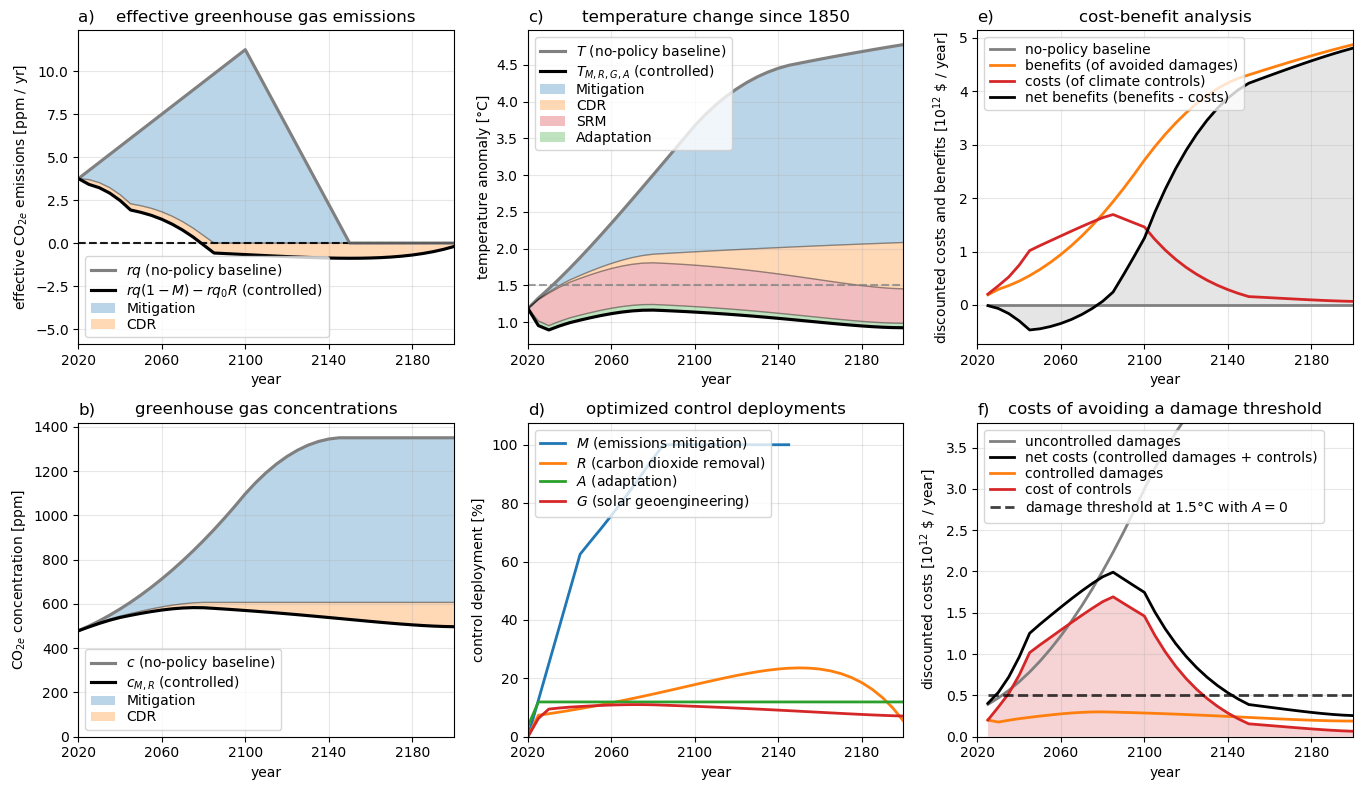

(Figure(PyObject <Figure size 1400x800 with 6 Axes>), PyObject[PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82cf460518>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82cfb45198>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82d8e985f8>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82d8d6b748>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82d8eb0ba8>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82d8dd0cf8>])

In [214]:
plot_state(SRM)

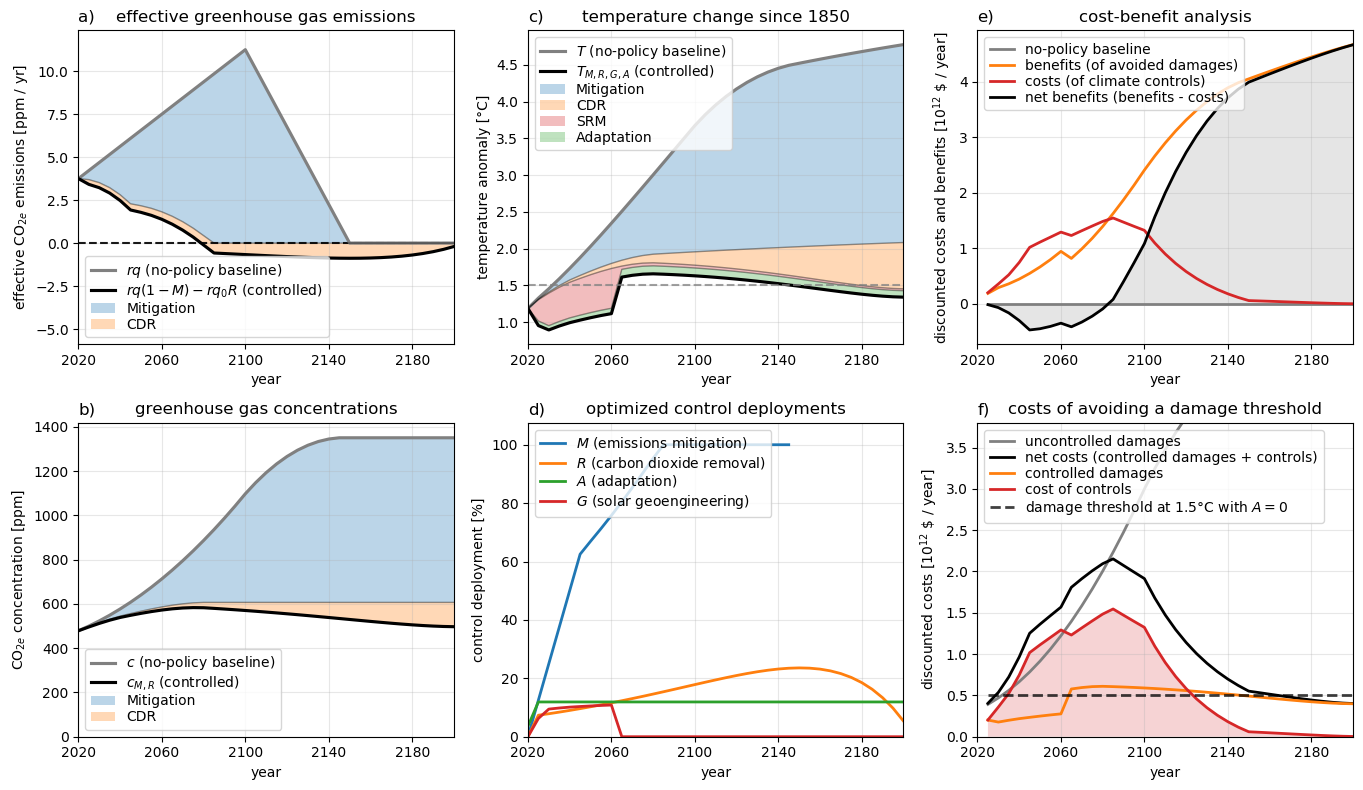

(Figure(PyObject <Figure size 1400x800 with 6 Axes>), PyObject[PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82ce6a04e0>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82ce776668>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82e21bb240>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82d0455be0>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82ce66f780>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82e47a2b00>])

In [215]:
plot_state(SRM_term)

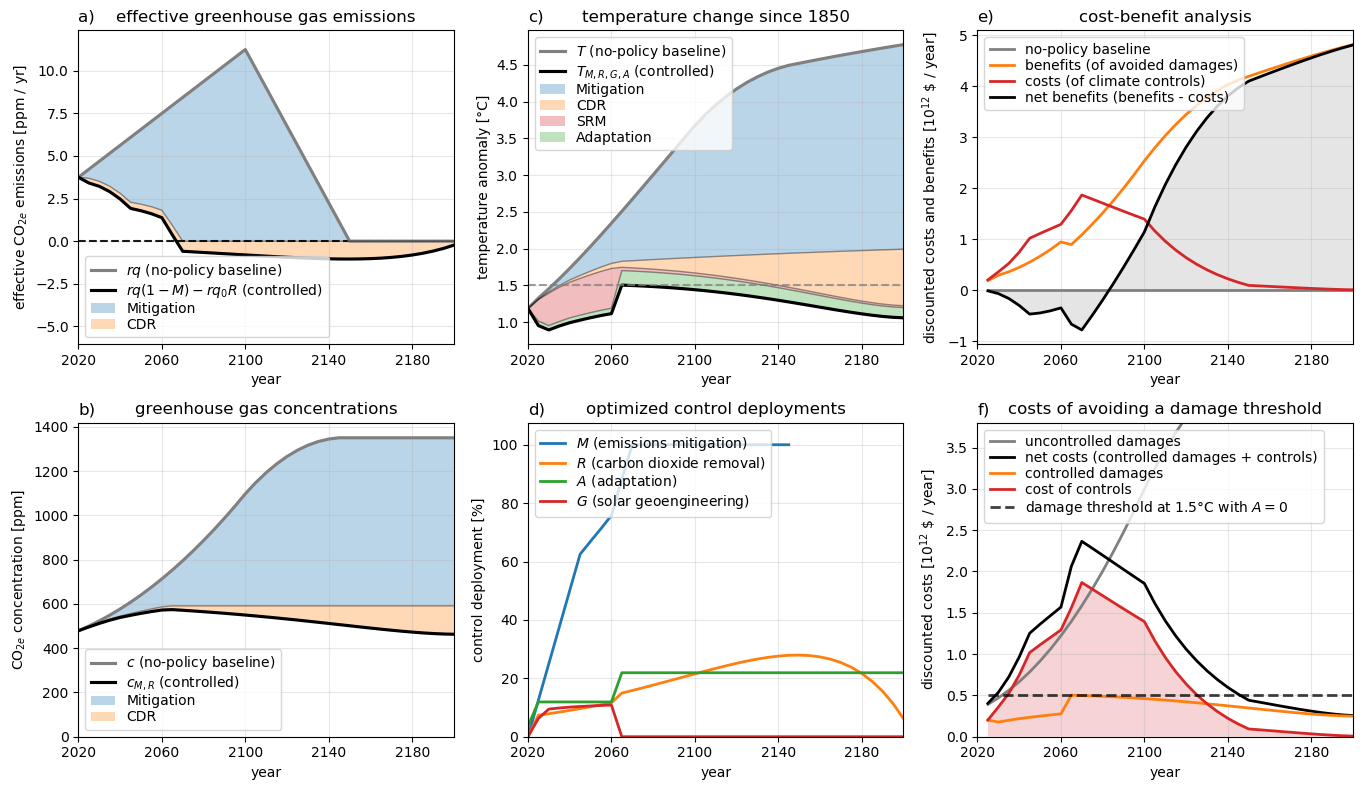

(Figure(PyObject <Figure size 1400x800 with 6 Axes>), PyObject[PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82e6821f28>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82e2b26780>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82e96434a8>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82e47d5208>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82e6b96048>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82e2e4ef98>])

In [216]:
plot_state(SRM_term_response)

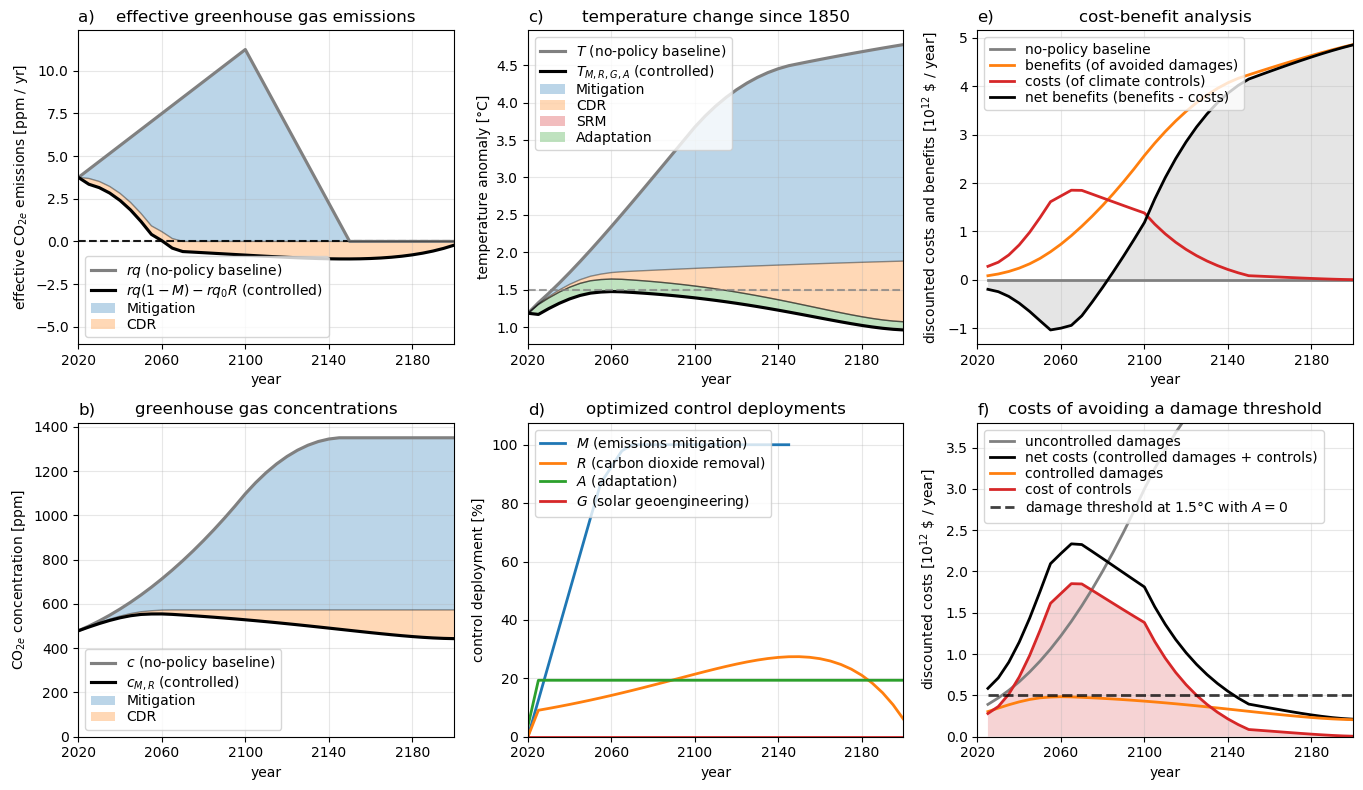

(Figure(PyObject <Figure size 1400x800 with 6 Axes>), PyObject[PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82d8d9fbe0>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82dbda44a8>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82cfbc2668>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82cc72aa58>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82cc930eb8>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f82cfc8a5f8>])

In [217]:
plot_state(noSRM)